<a href="https://colab.research.google.com/github/harshjpatel/LSTM/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# COVID-19 Data Analysis with LSTM Models

# This notebook contains functions to analyze COVID-19 data and predict cases using LSTM models. It also provides functions for data preprocessing.

## Dependencies
# Make sure to install the required dependencies:

# ```python
!pip install pandas matplotlib numpy tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

In [11]:
import pandas as pd

def parse_JHU_data():
    JHU_file = 'data/time_series_covid19_confirmed_US.csv'
    case_df = pd.read_csv(JHU_file)
    states = sorted(set(case_df['Province_State']))
    state_data = pd.DataFrame()
    for state in states:
        state_rows = case_df[case_df['Province_State'] == state]
        state_rows = state_rows.loc[:, '1/22/20':]

        state_data[state] = state_rows.sum()

    state_data = state_data.reset_index().rename(columns={'index': 'date'}).set_index('date')
    state_data.to_csv('data/state_cumulative.csv')
    daily_data = state_data.diff().iloc[1:]
    daily_data.to_csv('data/state_daily.csv')


In [12]:
def simple_LSTM():
    # from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Bidirectional
    from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
    from tensorflow.keras.regularizers import l2
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.preprocessing import StandardScaler

    state, state_short = 'Texas', 'TX'
    daily_file = 'data/state_daily.csv'
    daily_df = pd.read_csv(daily_file)
    daily_df['date'] = pd.to_datetime(daily_df['date'])
    daily_df = daily_df[['date', state]]
    moving_avg = daily_df[state].rolling(window=7).mean().iloc[6:]
    daily_df[state] = moving_avg

    mobility_file = 'data/mobility.csv'
    mobility_df = pd.read_csv(mobility_file)
    mobility_df['date'] = pd.to_datetime(mobility_df['date'])
    mobility_df = mobility_df[mobility_df['state'] == state_short]
    mobility_df.drop(columns=['state'], inplace=True)

    tweet_file = 'data/parseTwitterData.csv'
    tweet_df = pd.read_csv(tweet_file)
    tweet_df.rename(columns={'Date': 'date'}, inplace=True)
    tweet_df['date'] = pd.to_datetime(tweet_df['date'])
    tweet_df = tweet_df[tweet_df['State'] == state_short]
    tweet_df = tweet_df[
        ['date', 'StringencyIndex_WeightedAverage',
         'Tweet_CPL', 'Tweet_AS', 'Reply_swear', 'Reply_emo_anger']]

    X = daily_df.copy()
    X = pd.merge(X, mobility_df, on='date', how='outer')
    X = pd.merge(X, tweet_df, on='date', how='outer')

    # add lagged Y columns
    prediction_length = 7
    for i in range(prediction_length):
        X[f'Y{i}'] = X[state].shift(-i)

    X.dropna(inplace=True)
    display(X[X[state] <= 0])
    dates = X['date']
    X.drop(columns=['date'], inplace=True)

    # select the target columns
    Y = X.iloc[:, -prediction_length:].values
    # drop the target
    X = X.iloc[:, :-prediction_length]
    n_features = X.shape[-1]
    X = X.values
    X_train, X_CV = X[:450], X[450:]
    Y_train, Y_CV = Y[:450], Y[450:]
    dates_train, dates_CV = dates[:450], dates[450:]

    window_size = 14
    generator_train = TimeseriesGenerator(X_train, Y_train, length=window_size)
    generator_CV = TimeseriesGenerator(X_CV, Y_CV, length=window_size)

    model = Sequential()
    model.add(Bidirectional(LSTM(64,
                                 activation='relu',
                                 input_shape=(window_size, n_features),
                                 kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)
                                 )))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(prediction_length))
    model.build(input_shape=(None, window_size, n_features))
    model.compile(optimizer='adam', loss='mape',  metrics=['accuracy'])
    model.summary()

    model.fit(generator_train, epochs=100, batch_size=100)
    Y_pred_train = model.predict(generator_train)
    Y_pred_CV = model.predict(generator_CV)

    display(len(Y_pred_CV))

    mean_sqr_error = np.mean(
        [np.abs(Y_train[window_size:] - Y_pred_train) / Y_train[window_size:]]
    )
    display('training MAPE:', f'{100 * mean_sqr_error:.4f}')

    mean_sqr_error = np.mean(
        [np.abs(Y_CV[window_size:] - Y_pred_CV) / Y_CV[window_size:]]
    )
    display('validation MAPE:', f'{100 * mean_sqr_error:.4f}')

    for i in range(prediction_length):
        fig = plt.figure()
        plt.figure(figsize=(12, 8))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.plot(dates_train[window_size:], Y_train[window_size:, i], label='Y')
        ax1.plot(dates_train[window_size:], Y_pred_train[:, i], label='prediction')
        ax1.legend()
        ax1.set_title('training')
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.plot(dates_CV[window_size:], Y_CV[window_size:, i], label='Y')
        ax2.plot(dates_CV[window_size:], Y_pred_CV[:, i], label='prediction')
        ax2.legend()
        ax2.set_title('CV')
        fig.autofmt_xdate()
        plt.show()

    for i in range(7):
        fig = plt.figure()
        plt.figure(figsize=(12, 8))
        ax1 = fig.add_subplot()
        ax1.plot(dates_CV[window_size + i:window_size + i + prediction_length], Y_CV[window_size + i], label='Y')
        ax1.plot(dates_CV[window_size + i:window_size + i + prediction_length], Y_pred_CV[i], label='prediction')
        ax1.legend()
        fig.autofmt_xdate()
        plt.show()
        plt.close(fig)


In [13]:
def parse_mobility():
    mobility_files = ['data/Mobility/2020_US_Region_Mobility_Report.csv',
                      'data/Mobility/2021_US_Region_Mobility_Report.csv',
                      'data/Mobility/2022_US_Region_Mobility_Report.csv']
    mobility_df = pd.DataFrame()
    for file in mobility_files:
        df = pd.read_csv(file)
        cols_to_read = [5] + list(range(8, len(df.columns)))
        df = df.iloc[:, cols_to_read]
        df.iloc[:, 0] = df.iloc[:, 0].astype(str)
        # df.iloc[:, 1] = pd.to_datetime((df.iloc[:, 1]))
        mobility_df = pd.concat([mobility_df, df], ignore_index=True)

    print(mobility_df.info())
    mobility_df.rename(columns={mobility_df.columns[0]: 'state'}, inplace=True)
    mobility_df = mobility_df[mobility_df['state'] != 'nan']
    mobility_df['state'] = mobility_df['state'].apply(lambda x: x[3:])
    mobility_df.to_csv('data/mobility.csv', index=False)

In [14]:
def tmp():
    daily_file = 'data/state_daily.csv'
    daily_df = pd.read_csv(daily_file)
    daily_df['date'] = pd.to_datetime(daily_df['date'])
    daily_df = daily_df[['date', 'Illinois']]
    moving_avg = daily_df['Illinois'].rolling(window=7).mean().iloc[6:]
    daily_df['Illinois'] = moving_avg

    mobility_file = 'data/mobility.csv'
    mobility_df = pd.read_csv(mobility_file)
    mobility_df['date'] = pd.to_datetime(mobility_df['date'])
    mobility_df = mobility_df[mobility_df['state'] == 'IL']
    mobility_df.drop(columns=['state'], inplace=True)

    tweet_file = 'data/parseTwitterData.csv'
    tweet_df = pd.read_csv(tweet_file)
    tweet_df.rename(columns={'Date': 'date'}, inplace=True)
    tweet_df['date'] = pd.to_datetime(tweet_df['date'])
    tweet_df = tweet_df[tweet_df['State'] == 'IL']
    tweet_df = tweet_df[
        ['date', 'StringencyIndex_WeightedAverage', 'Tweet_CPL', 'Tweet_AS', 'Reply_swear', 'Reply_emo_anger']]

    X = pd.merge(daily_df, mobility_df, on='date', how='outer')
    X = pd.merge(X, tweet_df, on='date', how='outer')
    # scaler = StandardScaler()
    # scaler.fit(daily_df)
    X_states = ['Illinois', 'Indiana', 'Ohio', 'Wisconsin']
    # X_states = ['Illinois']
    # Y_states = ['Wisconsin']
    Y_states = ['Illinois']
    n_features = X.shape[-1]
    X.dropna(inplace=True)
    print(X.head())
    Y = X['Illinois'].copy()
    print(X.shape, Y.shape)

In [15]:
def parseTwitterData():
    twitterData = pd.read_csv('data/parseTwitterData.csv')
    print(twitterData.info())

<ipython-input-12-dff422902bda>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  daily_df['date'] = pd.to_datetime(daily_df['date'])


,date,Texas,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,StringencyIndex_WeightedAverage,Tweet_CPL,Tweet_AS,Reply_swear,Reply_emo_anger,Y0,Y1,Y2,Y3,Y4,Y5,Y6
38,2020-03-01,0.0,14.0,9.0,6.0,7.0,2.0,-2.0,8.33,0.0,0.000000,0.201081,0.000000,0.0,0.000000,0.000000,0.000000,0.428571,0.571429,1.142857
39,2020-03-02,0.0,8.0,7.0,8.0,4.0,4.0,-1.0,8.33,0.0,0.000000,0.546068,0.113182,0.0,0.000000,0.000000,0.428571,0.571429,1.142857,1.571429
40,2020-03-03,0.0,12.0,10.0,17.0,3.0,3.0,-2.0,8.33,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.428571,0.571429,1.142857,1.571429,1.857143
41,2020-03-04,0.0,6.0,5.0,-10.0,0.0,2.0,1.0,8.33,0.0,1.803333,0.017818,0.024242,0.0,0.428571,0.571429,1.142857,1.571429,1.857143,2.285714


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 128)               39424     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 48135 (188.03 KB)
Trainable params: 48135 (188.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 4s 30ms/step - loss: 105.9356 - accuracy: 0.2592
Epoch 2/100
4/4 [==============================] - 0s 27ms/step - loss: 99.6044 - accuracy: 0.2615
Epoch 3/100
4/4 [

146

'training MAPE:'

'15.0111'

'validation MAPE:'

'17.2784'

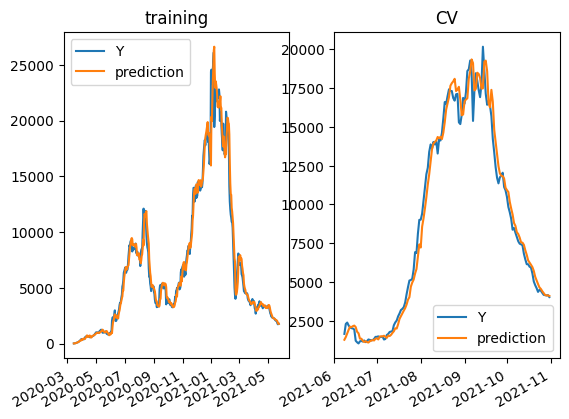

<Figure size 1200x800 with 0 Axes>

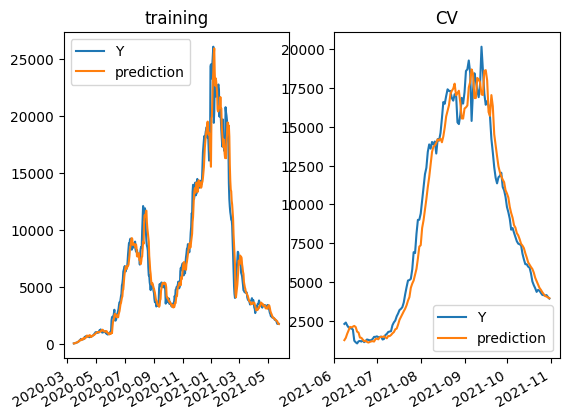

<Figure size 1200x800 with 0 Axes>

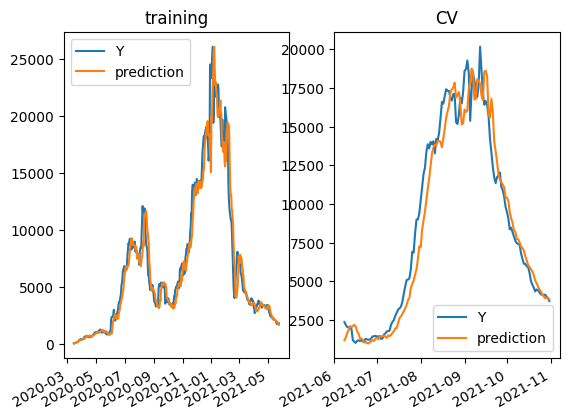

<Figure size 1200x800 with 0 Axes>

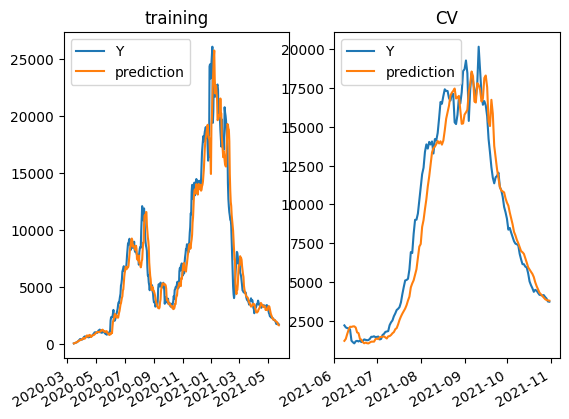

<Figure size 1200x800 with 0 Axes>

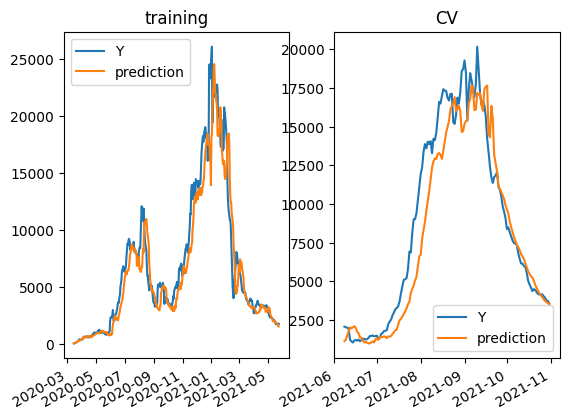

<Figure size 1200x800 with 0 Axes>

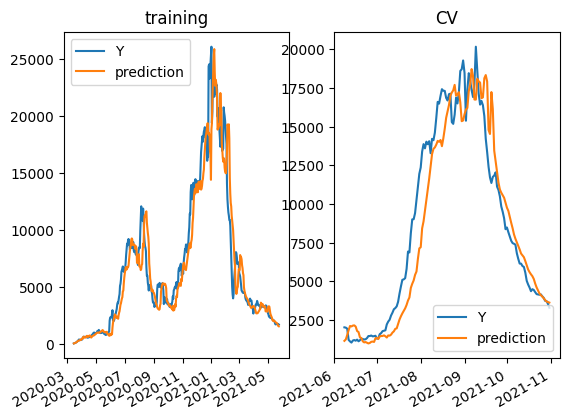

<Figure size 1200x800 with 0 Axes>

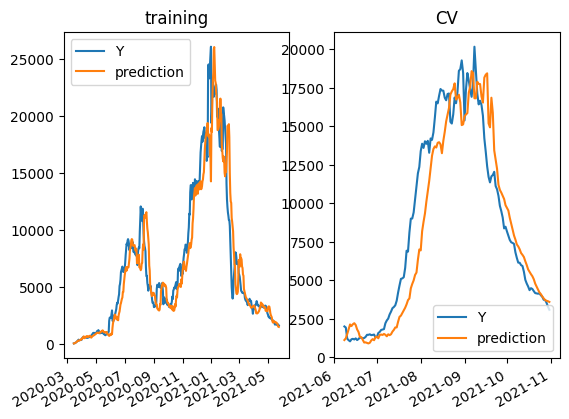

<Figure size 1200x800 with 0 Axes>

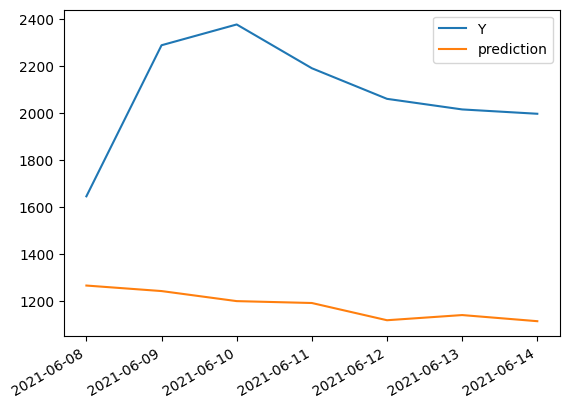

<Figure size 1200x800 with 0 Axes>

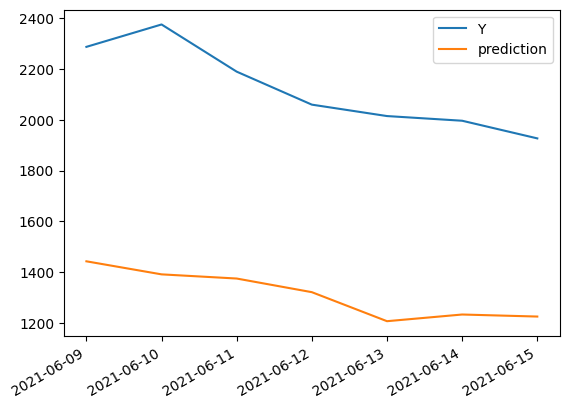

<Figure size 1200x800 with 0 Axes>

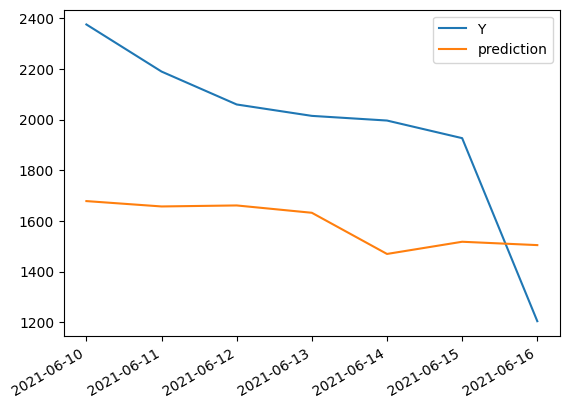

<Figure size 1200x800 with 0 Axes>

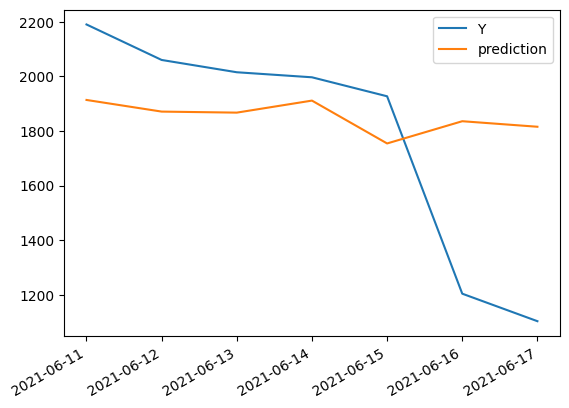

<Figure size 1200x800 with 0 Axes>

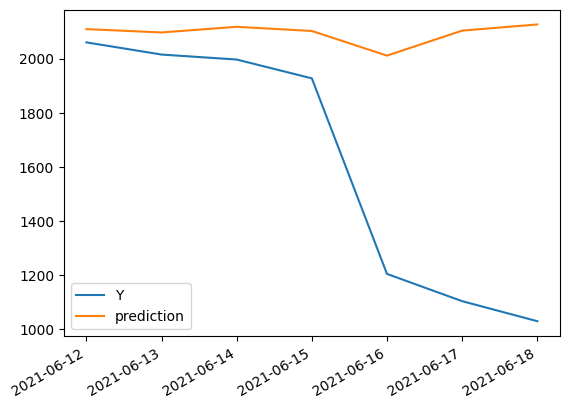

<Figure size 1200x800 with 0 Axes>

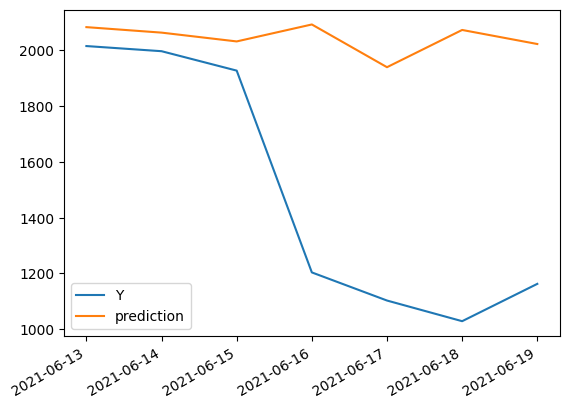

<Figure size 1200x800 with 0 Axes>

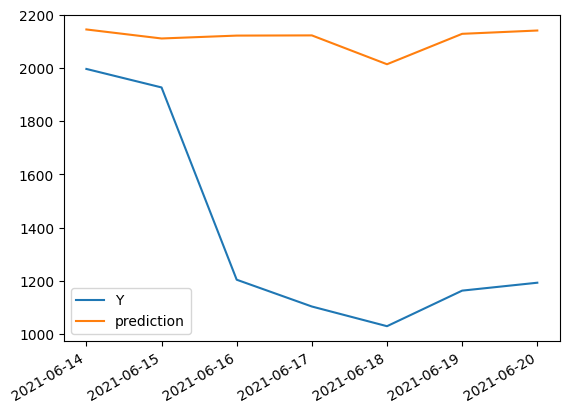

<Figure size 1200x800 with 0 Axes>

In [16]:
simple_LSTM()